In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU,InputLayer, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout

Using TensorFlow backend.


In [11]:
IMAGE_SIZE=[128, 128]

In [33]:
keras.backend.clear_session()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU,InputLayer, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [8]:
IMAGE_SIZE=[64, 64]
EPOCHS = 20
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 32

pth = 'E:/_DOWNLOADED/'
img_pth = 'E:/_DOWNLOADED/archive/'

train_df_main  = pd.read_csv(os.path.join(pth, 'train_df.csv'))


train_df_main .drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main .columns[2:-1]
labels

strategy = tf.distribute.get_strategy()

In [9]:
train_df_main['FilePath'] = train_df_main['FilePath'].str.replace('../input/data','E:/_DOWNLOADED/archive')
train_df_main['FilePath'].sample(10)

106341    E:/_DOWNLOADED/archive/images_012/images/00028...
62826     E:/_DOWNLOADED/archive/images_007/images/00015...
9285      E:/_DOWNLOADED/archive/images_002/images/00002...
98259     E:/_DOWNLOADED/archive/images_011/images/00025...
59468     E:/_DOWNLOADED/archive/images_007/images/00014...
67157     E:/_DOWNLOADED/archive/images_008/images/00016...
85785     E:/_DOWNLOADED/archive/images_010/images/00021...
83498     E:/_DOWNLOADED/archive/images_009/images/00020...
106112    E:/_DOWNLOADED/archive/images_012/images/00028...
110261    E:/_DOWNLOADED/archive/images_012/images/00030...
Name: FilePath, dtype: object

In [10]:
from sklearn.model_selection import train_test_split
train_df, discard = train_test_split(train_df_main, test_size = 0.7, random_state = 1993)

train_and_valid_set, test_set = train_test_split(train_df, test_size = 0.2, random_state = 1993)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = 1993)

In [11]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
      
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect')
    
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [12]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="FilePath", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [14]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = None, 
                                      x_col = "FilePath",
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set, 
                                                              test_df = test_set, 
                                                              train_df = train_set,
                                                              image_dir = None, 
                                                              x_col = "FilePath", 
                                                              y_cols = labels,
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0], 
                                                              target_h = IMAGE_SIZE[1])


getting train generator...
Found 21526 validated image filenames.
getting train and valid generators...
Found 21526 validated image filenames.
Found 5382 validated image filenames.
Found 6728 validated image filenames.


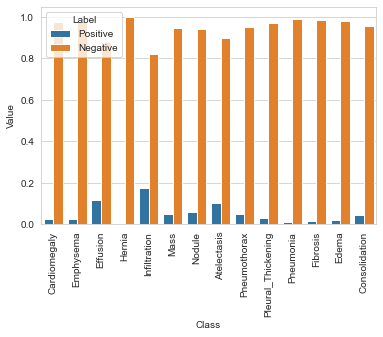

In [15]:
def compute_class_freqs(labels):
   
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    
    return positive_frequencies, negative_frequencies


# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

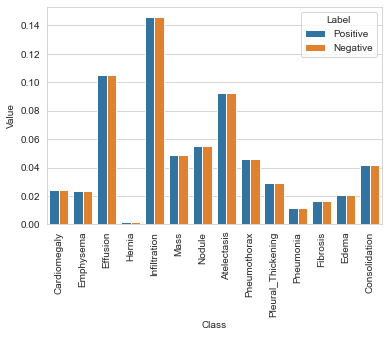

In [16]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [17]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        y_true = tf.cast(y_true, tf.float32)
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss

    return weighted_loss

In [21]:
keras.backend.clear_session()

In [18]:
from tensorflow.keras.callbacks import  LearningRateScheduler, EarlyStopping
from tensorflow.keras import callbacks
from keras import backend as K
tf.config.run_functions_eagerly(True)
# tf.config.experimental_run_functions_eagerly(True)

In [22]:
generator = keras.models.Sequential([
    keras.layers.Dense(128, activation = "relu",
    input_shape = (64,64,3)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64,activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32,activation = "sigmoid"),
])
# generator.summary()
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [64, 64, 32]),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(14, activation = "sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 32)        10848     
_________________________________________________________________
sequential_1 (Sequential)    (None, 14)                8391214   
Total params: 8,402,062
Trainable params: 8,402,062
Non-trainable params: 0
_________________________________________________________________


In [24]:
 
gan.compile(
    optimizer=tf.keras.optimizers.Adam( learning_rate=0.011, amsgrad=False), 
    #loss = 'binary_crossentropy',
    loss = get_weighted_loss(pos_weights, neg_weights),
    metrics = ['accuracy'])

In [26]:
def build_lrfn(lr_start=0.001000, lr_max=0.50000, 
               lr_min=0, lr_rampup_epochs=8, 
               lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

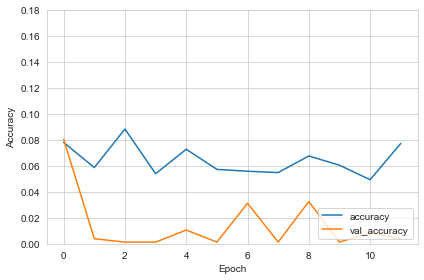

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.tight_layout()

In [172]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [106]:
keras.backend.clear_session()

In [107]:

generator = keras.models.Sequential([

    keras.layers.Dense(128, activation = "relu",
    input_shape = (128,128,3)),

    keras.layers.Dropout(0.4),
    keras.layers.Dense(64,activation = "relu"),

    keras.layers.Dropout(0.2),
    keras.layers.Dense(32,activation = "sigmoid"),

    
])
generator.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 128, 128)     512       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 128)     0         
_________________________________________________________________
dense_1 (Dense)              (None, 128, 128, 64)      8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
dense_2 (Dense)              (None, 128, 128, 32)      2080      
Total params: 10,848
Trainable params: 10,848
Non-trainable params: 0
_________________________________________________________________


In [51]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [128, 128, 32]),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation = "relu"),
    keras.layers.Dense(14, activation = "sigmoid")
    layers.Activation('sigmoid')
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                33554496  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 14)                462       
Total params: 33,557,038
Trainable params: 33,557,038
Non-trainable params: 0
_________________________________________________________________


In [52]:
gan = keras.models.Sequential([generator, discriminator])

In [53]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 32)      11616     
_________________________________________________________________
sequential_1 (Sequential)    (None, 14)                33557038  
Total params: 33,568,654
Trainable params: 33,568,270
Non-trainable params: 384
_________________________________________________________________


In [54]:
from tensorflow.keras.callbacks import  LearningRateScheduler, EarlyStopping
from tensorflow.keras import callbacks

In [55]:
# we have non exclusive classes in many cases so we choose binary cross entropy 
optimizer = keras.optimizers.Adam(lr=0.01)
gan.compile(optimizer=optimizer,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
history = gan.fit(train_generator, epochs=15,
                    callbacks = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                        patience = 5,
                                        
                                        mode = 'max'),
                    validation_data=valid_generator)

Epoch 1/15
337/337 [==============================] - 399s 1s/step - loss: 0.6975 - accuracy: 0.5284 - val_loss: 0.6931 - val_accuracy: 0.5552
Epoch 2/15
337/337 [==============================] - 410s 1s/step - loss: 0.6932 - accuracy: 0.5608 - val_loss: 0.6931 - val_accuracy: 0.5552
Epoch 3/15
337/337 [==============================] - 406s 1s/step - loss: 0.6932 - accuracy: 0.5608 - val_loss: 0.6931 - val_accuracy: 0.5552
Epoch 4/15
337/337 [==============================] - 405s 1s/step - loss: 0.6931 - accuracy: 0.5608 - val_loss: 0.6931 - val_accuracy: 0.5552
Epoch 5/15
337/337 [==============================] - 405s 1s/step - loss: 0.6932 - accuracy: 0.5608 - val_loss: 0.6931 - val_accuracy: 0.5552
Epoch 6/15
337/337 [==============================] - 430s 1s/step - loss: 0.6932 - accuracy: 0.5607 - val_loss: 0.6931 - val_accuracy: 0.5552


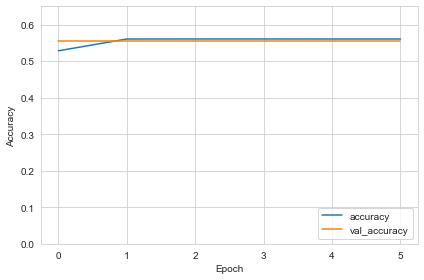

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, .65])
plt.legend(loc='lower right')
plt.tight_layout()

In [62]:
test_loss, test_acc = gan.evaluate(test_generator, verbose=2)

106/106 - 98s - loss: 0.6931 - accuracy: 0.5641


In [63]:
print("Test accuracy: ",test_acc," Test loss: ",test_loss)

Test accuracy:  0.564060628414154  Test loss:  0.6931465864181519
